# Rectangular Integration of RNA+ADT

In this tutorial, we demonstrate how to integrate a dataset consisting of RNA and ADT data. We will also walk through the inference process and the some of the outputs generated by MIDAS.

## Step 1: Downloading the Demo Data

In [ ]:
from scmidas.data import download_data
download_data('wnn_full_3batch', './')

## Step 2: Setting Up the Environment

Before we begin, ensure that the required environment is set up. This includes importing the necessary packages and dependencies.

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

from scmidas.config import load_config
from scmidas.model import MIDAS
from scmidas.utils import load_predicted
import lightning as L

import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(4, 4))

## Step 3: Configuring the Model

In this step, we configure the model.

In [ ]:
configs = load_config() # refer to Tutotrials/Advanced/Development Instructions for details

In [ ]:
task = 'wnn_full_3batch'
model = MIDAS.configure_data_from_dir(configs, './dataset/'+task+'/data')

INFO:root:Input data: 
         #CELL  #RNA  #ADT  #VALID_RNA  #VALID_ADT
BATCH 0   6378  3617   224        3617         224
BATCH 1   6952  3617   224        3617         224
BATCH 2   8908  3617   224        3617         224


## Step 4: Training the Model (~4h)

After configuring the model, we proceed with training. This step typically takes around 4 hours using a single V100 GPU, depending on your system's specifications. If you prefer a quicker result, you can set `max_epochs=500` for a reasonable outcome, instead of the default `max_epochs=2000` for the best result.

In [4]:
trainer = L.Trainer(max_epochs=2000)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
trainer.fit(model=model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | net  | VAE           | 8.2 M  | train
1 | dsc  | Discriminator | 39.2 K | train
-----------------------------------------------
8.2 M     Trainable params
0         Non-trainable params
8.2 M     Total params
32.817    Total estimated model params size (MB)
154       Modules in train mode
0         Modules in eval mode
INFO:root:Total number of samples: 22238 from 3 datasets.
INFO:root:Using MultiBatchSampler for data loading.
/root/anaconda3/envs/pl/lib/python3.12/site-packages/torch/utils/data/sampler.py:76: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(
INFO:root:DataLoader created with batch size 256 and 20 workers.


Epoch 500: 100%|██████████| 105/105 [00:07<00:00, 14.72it/s, v_num=6, loss_/recon_loss_step=2.5e+3, loss_/kld_loss_step=105.0, loss_/consistency_loss_step=20.60, loss/net_step=2.53e+3, loss/dsc_step=97.70, loss_/recon_loss_epoch=2.34e+3, loss_/kld_loss_epoch=105.0, loss_/consistency_loss_epoch=21.40, loss/net_epoch=2.37e+3, loss/dsc_epoch=93.00] 

INFO:root:Checkpoint successfully saved to "./saved_models/model_epoch500_20241217-031018.pt".
INFO:root:Checkpoint saved for epoch "500" at "./saved_models/model_epoch500_20241217-031018.pt".


Epoch 1000: 100%|██████████| 105/105 [00:07<00:00, 14.16it/s, v_num=6, loss_/recon_loss_step=2.46e+3, loss_/kld_loss_step=104.0, loss_/consistency_loss_step=18.30, loss/net_step=2.48e+3, loss/dsc_step=93.10, loss_/recon_loss_epoch=2.3e+3, loss_/kld_loss_epoch=102.0, loss_/consistency_loss_epoch=20.60, loss/net_epoch=2.33e+3, loss/dsc_epoch=92.70]

INFO:root:Checkpoint successfully saved to "./saved_models/model_epoch1000_20241217-041043.pt".
INFO:root:Checkpoint saved for epoch "1000" at "./saved_models/model_epoch1000_20241217-041043.pt".


Epoch 1500: 100%|██████████| 105/105 [00:07<00:00, 14.12it/s, v_num=6, loss_/recon_loss_step=2.36e+3, loss_/kld_loss_step=102.0, loss_/consistency_loss_step=18.40, loss/net_step=2.39e+3, loss/dsc_step=93.80, loss_/recon_loss_epoch=2.28e+3, loss_/kld_loss_epoch=101.0, loss_/consistency_loss_epoch=21.00, loss/net_epoch=2.31e+3, loss/dsc_epoch=92.60]

INFO:root:Checkpoint successfully saved to "./saved_models/model_epoch1500_20241217-051155.pt".
INFO:root:Checkpoint saved for epoch "1500" at "./saved_models/model_epoch1500_20241217-051155.pt".


Epoch 1999: 100%|██████████| 105/105 [00:06<00:00, 15.06it/s, v_num=6, loss_/recon_loss_step=2.38e+3, loss_/kld_loss_step=102.0, loss_/consistency_loss_step=18.00, loss/net_step=2.41e+3, loss/dsc_step=94.80, loss_/recon_loss_epoch=2.27e+3, loss_/kld_loss_epoch=101.0, loss_/consistency_loss_epoch=20.70, loss/net_epoch=2.3e+3, loss/dsc_epoch=92.80] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 105/105 [00:06<00:00, 15.03it/s, v_num=6, loss_/recon_loss_step=2.38e+3, loss_/kld_loss_step=102.0, loss_/consistency_loss_step=18.00, loss/net_step=2.41e+3, loss/dsc_step=94.80, loss_/recon_loss_epoch=2.27e+3, loss_/kld_loss_epoch=101.0, loss_/consistency_loss_epoch=20.70, loss/net_epoch=2.3e+3, loss/dsc_epoch=92.80]


INFO:root:Checkpoint successfully saved to "./saved_models/model_epoch2000_20241217-061343.pt".
INFO:root:Checkpoint saved for epoch "2000" at ./saved_models/model_epoch2000_20241217-061343.pt".


## Step 5: Predicting

Once the model is trained, we can run `predict()` to obtain various outputs from MIDAS.

In [ ]:
model.predict('./predict/'+task,         
        joint_latent=True,
        mod_latent=True,
        impute=True,
        batch_correct=True,
        translate=True,
        input=True)

## Outputs: Joint Embeddings

In this step, we explore the various outputs generated by MIDAS.
First, we load the cell-type and batch index labels associated with the dataset.

In [ ]:
label = []
batch_id = []
for i in ['p1_0', 'p5_0', 'p8_0']:
    label.append(pd.read_csv('./dataset/'+task+'/label/%s.csv'%i, index_col=0).values.flatten())
    batch_id.append([i] * len(label[-1]))
labels = np.concatenate(label)
batch_ids = np.concatenate(batch_id)

The joint embeddings consist of two components: `biological information (c)` and `technical information (u)`.
To analyze them, we split the embeddings and visualize them separately.

INFO:root:Loading predicted variables ...
INFO:root:Loading batch 0: z, joint
100%|██████████| 25/25 [00:00<00:00, 287.99it/s]
INFO:root:Loading batch 1: z, joint
100%|██████████| 28/28 [00:00<00:00, 251.03it/s]
INFO:root:Loading batch 2: z, joint
100%|██████████| 35/35 [00:00<00:00, 243.35it/s]
INFO:root:Converting to numpy ...
INFO:root:Converting batch 0: s, joint
INFO:root:Converting batch 0: z, joint
INFO:root:Converting batch 1: s, joint
INFO:root:Converting batch 1: z, joint
INFO:root:Converting batch 2: s, joint
INFO:root:Converting batch 2: z, joint
... storing 'batch' as categorical
... storing 'label' as categorical


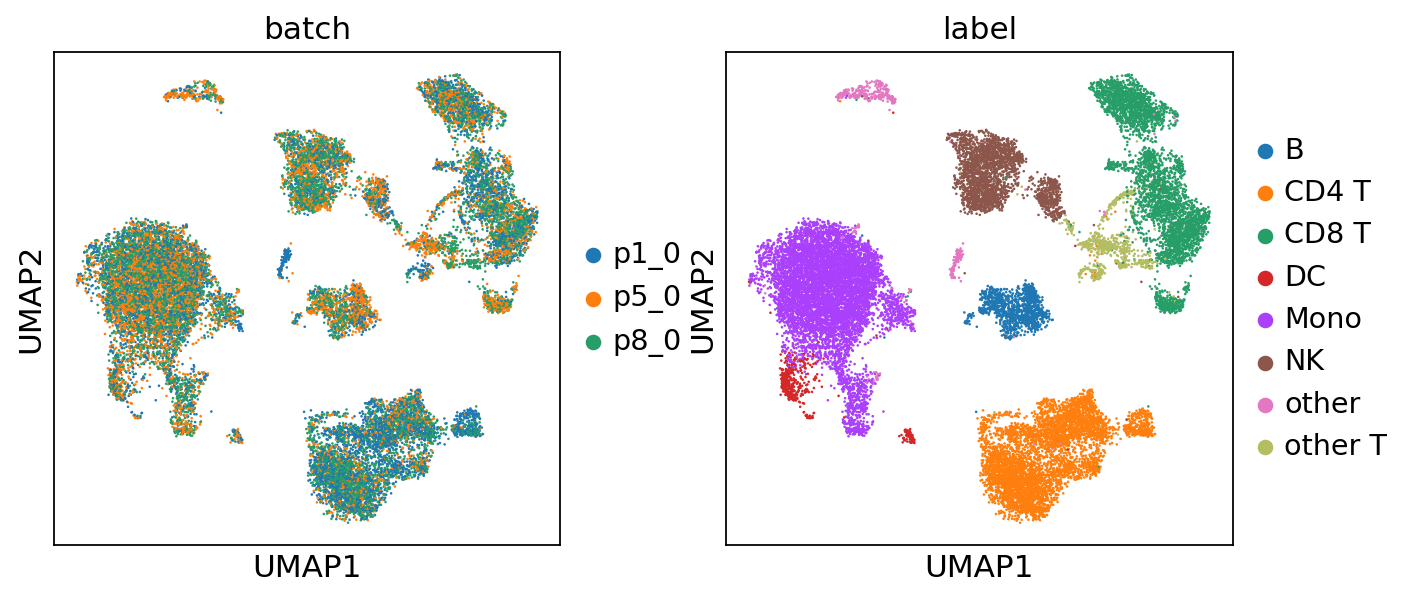

... storing 'batch' as categorical
... storing 'label' as categorical


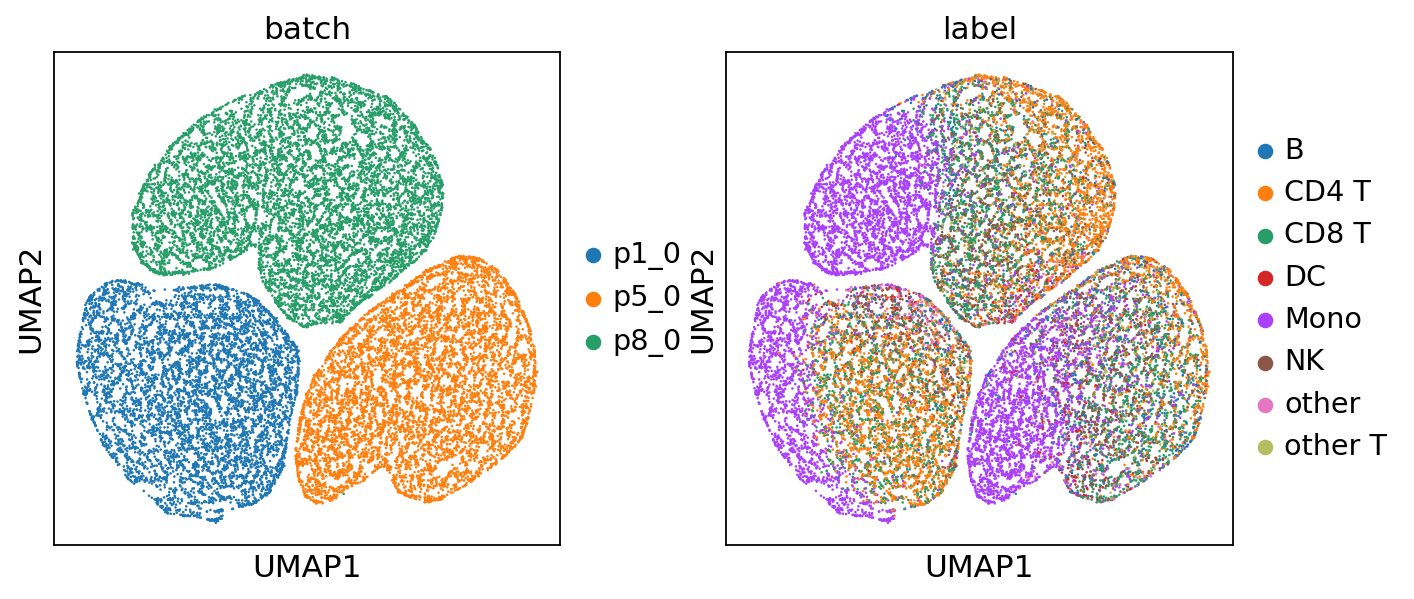

In [ ]:
joint_embeddings = load_predicted('./predict/'+task, model.combs, joint_latent=True)

adata_bio = sc.AnnData(joint_embeddings['z']['joint'][:, :model.dim_c])
adata_tech = sc.AnnData(joint_embeddings['z']['joint'][:, model.dim_c:])

adata_bio.obs['batch'] = batch_ids
adata_bio.obs['label'] = labels
adata_tech.obs['batch'] = batch_ids
adata_tech.obs['label'] = labels
# shuffle
sc.pp.subsample(adata_bio, fraction=1)
sc.pp.subsample(adata_tech, fraction=1)
for adata in [adata_bio, adata_tech]:
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['batch', 'label'], ncols=2)

For quick visualization of the joint embeddings, we provide an API that allows for efficient plotting.

In [ ]:
# adata, _ = model.get_emb_umap('../predict/'+task)

## Outputs: Modality-specific Embeddings

MIDAS can generate embeddings for each modality. Here, we check the alignment among modalities by visualizing them with UMAP.

In [ ]:
mod_embeddings = load_predicted('./predict/'+task, model.combs, mod_latent=True, group_by='batch')
batch_names = ['p1_0', 'p5_0', 'p8_0']
adata_list = []
for i in range(model.dims_s['joint']):
    for m in model.mods+['joint']:
        if m in mod_embeddings[i]['z']:
            adata = sc.AnnData(mod_embeddings[i]['z'][m][:, :model.dim_c])
            adata.obs['batch'] = batch_names[i]
            adata.obs['modality'] = m
            adata.obs['label'] = label[i]
            adata_list.append(adata)
adata_mod_concat = sc.concat(adata_list)
for i in adata_mod_concat.obs:
    adata_mod_concat.obs[i] = adata_mod_concat.obs[i].astype('category')
sc.pp.neighbors(adata_mod_concat)
# shuffle
sc.pp.subsample(adata_mod_concat, fraction=1)
sc.tl.umap(adata_mod_concat)

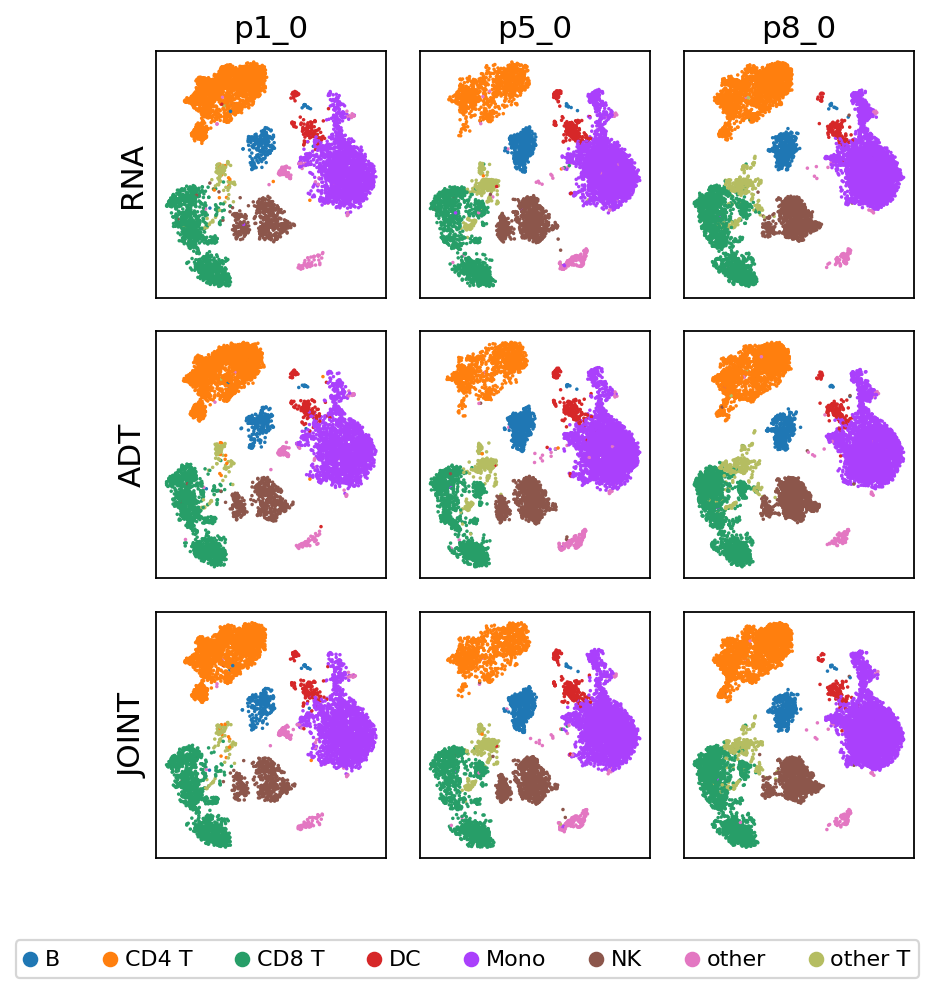

In [17]:
# setup figure
nrows = len(model.mods) + 1
ncols = model.dims_s['joint']
point_size = 10

fig, ax = plt.subplots(nrows, ncols, figsize=[2 * ncols, 2 * nrows])

# set up the name of modalities and batch
mod_names = model.mods + ['joint']

# iteratively scatter the data
for i, mod in enumerate(mod_names):
    for b in range(model.dims_s['joint']):
        # filter data
        adata = adata_mod_concat[
            (adata_mod_concat.obs['modality'] == mod) & 
            (adata_mod_concat.obs['batch'] == batch_names[b])
        ].copy()
        if len(adata):
            sc.pl.umap(adata, color='label', show=False, ax=ax[i, b], s=point_size)
            ax[i, b].get_legend().set_visible(False)
            handles, labels_ = ax[i, b].get_legend_handles_labels()
        ax[i, b].set_xticks([])
        ax[i, b].set_yticks([])
        ax[i, b].set_xlabel('')
        if b==0:
            ax[i, b].set_ylabel(mod.upper())
        else:
            ax[i, b].set_ylabel('')
        if i==0:
            ax[i, b].set_title(batch_names[b])
        else:
            ax[i, b].set_title('')
# create global legend
fig.legend(handles, labels_, loc='center', bbox_to_anchor=(0.5, -0.02), ncol=len(labels_), fontsize=10)

# adjust the figure
plt.tight_layout(rect=[0.1, 0.05, 1, 1])
plt.show()

## Outputs: Batch-corrected Counts

By using the `standard noise`, we can generate the batch-corrected data. To validate the batch effect in the predicted multi-modalities counts, we use PCA+WNN to gain the joint embeddings for them. First of all, we load the batch-corrected counts.

In [ ]:
batch_corrected_counts = load_predicted('./predict/'+task, model.combs, batch_correct=True)

Save the data to CSV files for later use in R.

In [ ]:
pd.DataFrame(batch_corrected_counts['x_bc']['rna']).T.to_csv('temp_rna.csv', index=True)
pd.DataFrame(batch_corrected_counts['x_bc']['adt']).T.to_csv('temp_adt.csv', index=True)

Set up the R environment.

In [ ]:
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
importr('Seurat')
importr('SeuratDisk')
importr('dplyr')
importr('Signac')

PCA+WNN

In [ ]:
ro.r('''
rna <- read.csv('./temp_rna.csv', header=TRUE, row.names=1)
adt <- read.csv('./temp_adt.csv', header=TRUE, row.names=1)
obj <- CreateSeuratObject(counts = rna, assay = "rna")
obj[["adt"]] <- CreateAssayObject(counts = adt)
obj <- subset(obj, subset = nCount_rna > 0 & nCount_adt > 0)
print(obj)
DefaultAssay(obj) <- 'rna'
VariableFeatures(obj) <- rownames(obj)
obj <-  NormalizeData(obj) %>%
        # FindVariableFeatures(nfeatures = 2000) %>%
        ScaleData() %>%
        RunPCA(reduction.name = "pca_rna", verbose = F)
print('finish rna')
DefaultAssay(obj) <- 'adt'
VariableFeatures(obj) <- rownames(obj)
obj <-  NormalizeData(obj, normalization.method = "CLR", margin = 2) %>%
        ScaleData() %>%
        RunPCA(reduction.name = "pca_adt", verbose = F)
print('finish adt')
print('WNN ...')
obj <- FindMultiModalNeighbors(obj, list("pca_rna", "pca_adt"), list(1:32, 1:32))
obj <- RunUMAP(obj, nn.name = "weighted.nn", reduction.name = "umap")
''')

... storing 'label' as categorical
... storing 'batch' as categorical


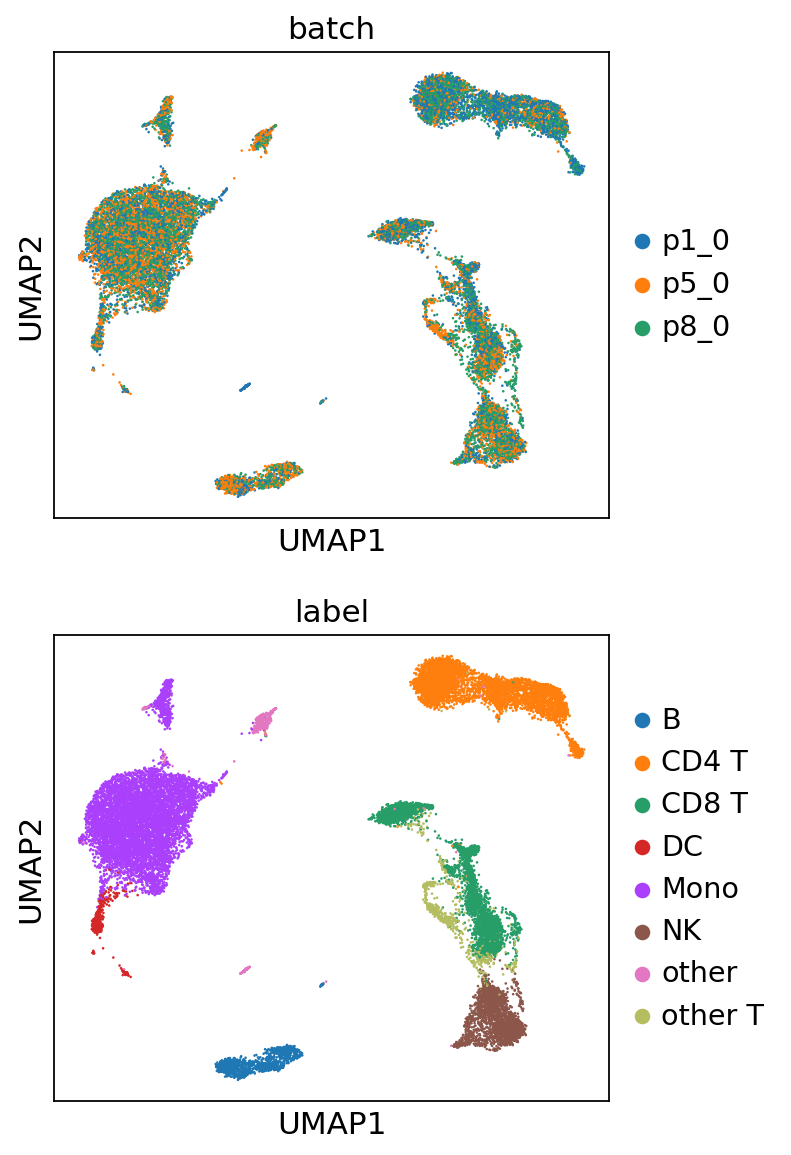

In [ ]:
# Create an AnnData object with 'X' not being used, so we initialize it with all zeros
adata = sc.AnnData(np.zeros([len(batch_corrected_counts['x_bc']['rna']), 1]))
adata.obs['label'] = labels
adata.obs['batch'] = batch_ids
f = ro.r('''DimPlot(obj, reduction='umap')''')
adata.obsm['umap'] = pd.DataFrame(f[0]).iloc[:2].T.values
# shuffle
sc.pp.subsample(adata, fraction=1)
sc.pl.umap(adata, color=['batch', 'label'], ncols=1)

Similarly, we load the raw counts and visualize the UMAP using the same procedure.

In [ ]:
inputs = load_predicted('../predict/'+task, model.combs, input=True, group_by='modality')

In [17]:
pd.DataFrame(inputs['x']['rna']).T.to_csv('temp_rna.csv', index=True)
pd.DataFrame(inputs['x']['adt']).T.to_csv('temp_adt.csv', index=True)

In [ ]:
ro.r('''
rna <- read.csv('./temp_rna.csv', header=TRUE, row.names=1)
adt <- read.csv('./temp_adt.csv', header=TRUE, row.names=1)
obj <- CreateSeuratObject(counts = rna, assay = "rna")
obj[["adt"]] <- CreateAssayObject(counts = adt)
obj <- subset(obj, subset = nCount_rna > 0 & nCount_adt > 0)
print(obj)
DefaultAssay(obj) <- 'rna'
VariableFeatures(obj) <- rownames(obj)
obj <-  NormalizeData(obj) %>%
        # FindVariableFeatures(nfeatures = 2000) %>%
        ScaleData() %>%
        RunPCA(reduction.name = "pca_rna", verbose = F)
print('finish rna')
DefaultAssay(obj) <- 'adt'
VariableFeatures(obj) <- rownames(obj)
obj <-  NormalizeData(obj, normalization.method = "CLR", margin = 2) %>%
        ScaleData() %>%
        RunPCA(reduction.name = "pca_adt", verbose = F)
print('finish adt')
print('WNN ...')
obj <- FindMultiModalNeighbors(obj, list("pca_rna", "pca_adt"), list(1:32, 1:32))
obj <- RunUMAP(obj, nn.name = "weighted.nn", reduction.name = "umap")
''')

... storing 'label' as categorical
... storing 'batch' as categorical


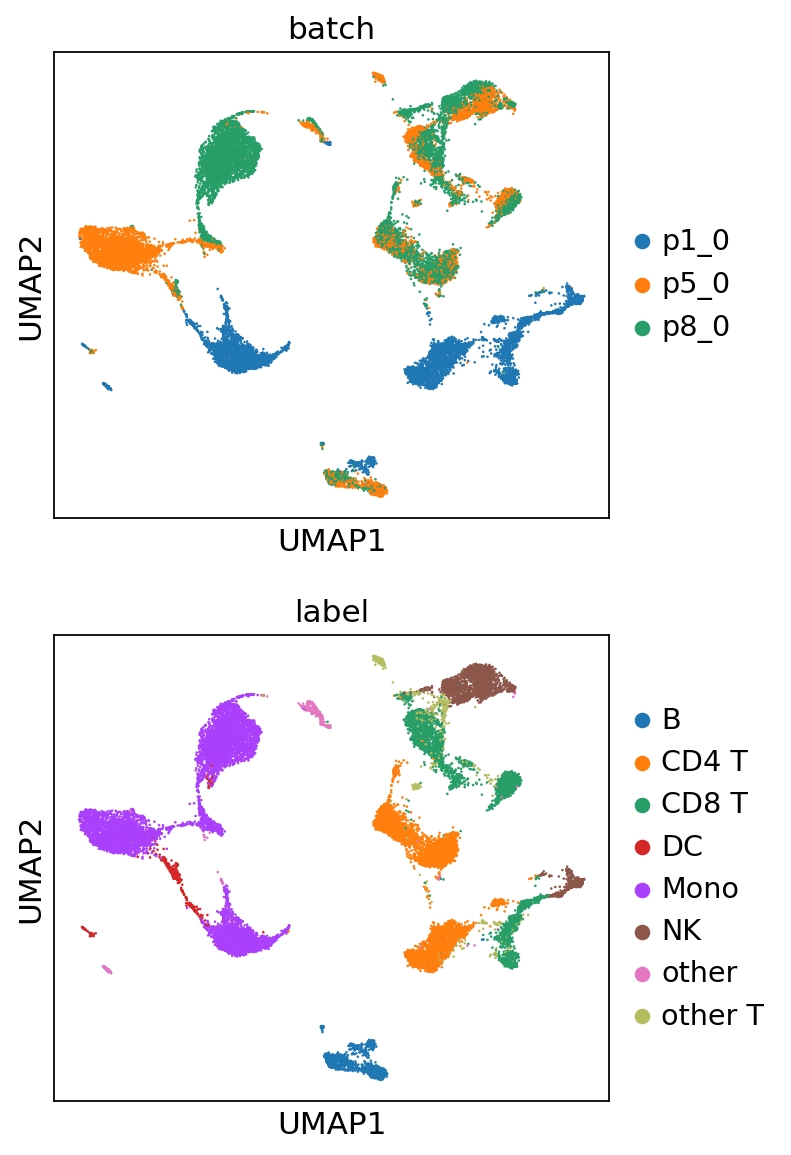

In [19]:
adata = sc.AnnData(np.zeros([len(inputs['x']['rna']), 1]))
adata.obs['label'] = labels
adata.obs['batch'] = batch_ids
f = ro.r('''
     DimPlot(obj, reduction='umap')
     ''')
adata.obsm['umap'] = pd.DataFrame(f[0]).iloc[:2].T.values
# shuffle
sc.pp.subsample(adata, fraction=1)
sc.pl.umap(adata, color=['batch', 'label'], ncols=1)

For the raw data, prominent batch effects are observed, where clusters of cells are segregated based on batches.
For the MIDAS batch-corrected counts, these batch effects are effectively removed, leading to well-integrated clusters.